In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

from pytorch_model import Classifier

In [2]:
df = pd.read_csv('data/train_human_metrics.csv')

1.2398298204837868 5.102899995945751 3.8630701754619636
-0.460943556311397 1.2186521721503265 1.6795957284617236


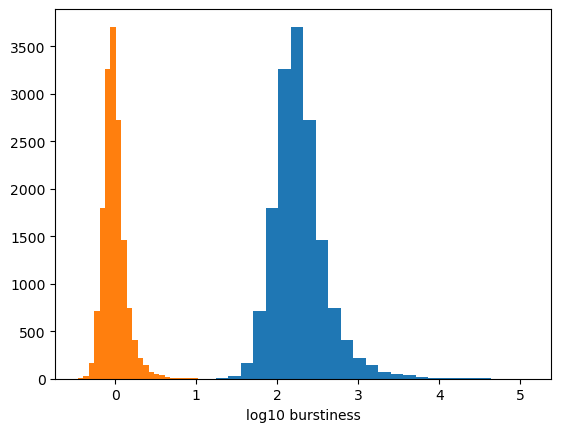

In [3]:
# want to renormlize burstiness metric
log_burst = np.log10(df['met1'].values)

new_log_burst = (log_burst-2.3)/2.3
plt.hist(log_burst, bins=25)
plt.hist(new_log_burst, bins=25)
plt.xlabel('log10 burstiness')

print(min(log_burst), max(log_burst), max(log_burst)-min(log_burst))
print(min(new_log_burst), max(new_log_burst), max(new_log_burst)-min(new_log_burst))

(array([ 1997.,   435.,   240.,   185.,   144.,   155.,   234.,   340.,
          643., 11221.]),
 array([-9.9970e-01, -7.9975e-01, -5.9980e-01, -3.9985e-01, -1.9990e-01,
         5.0000e-05,  2.0000e-01,  3.9995e-01,  5.9990e-01,  7.9985e-01,
         9.9980e-01]),
 <BarContainer object of 10 artists>)

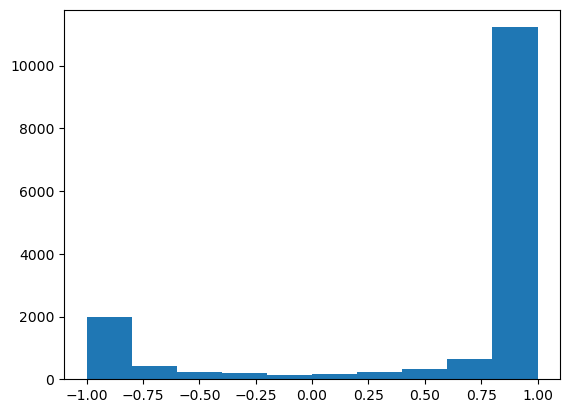

In [4]:
plt.hist(df['met5'])

In [5]:
metrics_cols = ['met%i'%(i+1) for i in range(5)]
arr =  df[metrics_cols].values

# normalize the burstiness metric
arr[:,0] = (np.log10(arr[:,0]) - 2.3) / 2.3

---
### Load pytorch tensors

In [6]:
%%time
human_tensors = torch.load('data/train_tensor.pt')
N_essays = len(human_tensors)
N_essays

CPU times: user 1.15 s, sys: 6.35 s, total: 7.5 s
Wall time: 12.7 s


15594

1668

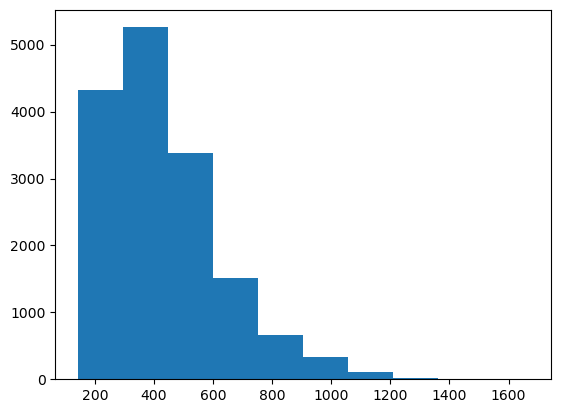

In [7]:
word_counts = np.array([t.shape[0] for t in human_tensors])
plt.hist(word_counts)
max(word_counts)

In [8]:
# first col is GPT, second is human
y = torch.cat((torch.zeros((1,N_essays) ), torch.ones((1,N_essays) ))).T

In [9]:
from sklearn.model_selection import train_test_split
inds = np.arange(N_essays)
train_inds, test_inds = train_test_split(inds, test_size=0.2, random_state=8675309)

In [12]:
from torch.nn.utils.rnn import pad_sequence
from torch import nn

In [13]:
# define model
model = Classifier(use_LSTM=True)
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()

In [20]:
batch_size = 25
batch_num = 0

batch_loss=[]
#while batch_num*batch_size < len(train_inds):
while batch_num*batch_size < 100:
    
    # Zero your gradients for every batch!
    optimizer.zero_grad()
        
    # define batch indicies
    i0 = batch_num*batch_size
    if i0+batch_size < len(train_inds):
        i1 = i0+batch_size
    else:
        i1 =len(train_inds)
    batch_inds = train_inds[i0:i1]
    y_true = y[batch_inds]
    
    # gotta do some padding to put everything in batches    
    x_text = pad_sequence([human_tensors[ind] for ind in batch_inds])
    x_text.requires_grad = True
    
    # extract the normalized metrics
    x_met = torch.from_numpy(arr[batch_inds]).float()
    x_met.requires_grad = True
    
    y_probs = model(x_text,x_met)

    L = loss(y_probs, y_true)
    batch_loss.append(L)
    L.backward()
    
    optimizer.step()

    batch_num+=1

In [18]:
output

tensor(0.6911, grad_fn=<DivBackward1>)

In [15]:
x_met.shape

torch.Size([25, 5])

In [16]:
x_text.shape

torch.Size([705, 25, 300])

In [17]:
model(x_text,x_met)

tensor([[0.4972, 0.5028],
        [0.4976, 0.5024],
        [0.4979, 0.5021],
        [0.4986, 0.5014],
        [0.4967, 0.5033],
        [0.5009, 0.4991],
        [0.4980, 0.5020],
        [0.5000, 0.5000],
        [0.4984, 0.5016],
        [0.4974, 0.5026],
        [0.4965, 0.5035],
        [0.4972, 0.5028],
        [0.4962, 0.5038],
        [0.4978, 0.5022],
        [0.4973, 0.5027],
        [0.4966, 0.5034],
        [0.4965, 0.5035],
        [0.4997, 0.5003],
        [0.4982, 0.5018],
        [0.4981, 0.5019],
        [0.4974, 0.5026],
        [0.4990, 0.5010],
        [0.4988, 0.5012],
        [0.5004, 0.4996],
        [0.4967, 0.5033]], grad_fn=<SoftmaxBackward0>)

In [ ]:
input_size